Based on : https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-tsne.ipynb

# Image t-SNE

This notebook will take you through the process of generating a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) of a set of images, using a feature vector for each image derived from the activations of the last fully-connected layer in a pre-trained convolutional neural network (convnet).

### Installation and dependencies

The code for this notebook has a number of dependencies, which can usually be installed with `pip`. You will need:

 * [simplejson](https://pypi.python.org/pypi/simplejson/)
 * [matplotlib](http://matplotlib.org)
 * [scikit-learn](scikit-learn.org)
 * [Pillow](https://python-pillow.org/)
 * [cPickle](https://docs.python.org/2/library/pickle.html)
 * [tqdm](https://pypi.python.org/pypi/tqdm)
 
Additionally, if you'd like to follow the last section which converts the t-SNE points to a grid assignment, you'll need [RasterFairy](https://github.com/Quasimondo/RasterFairy), which can be installed with `pip` in with the following command.

    pip install git+https://github.com/Quasimondo/RasterFairy

### Prepare dataset

This notebook assumes you have already extracted features for a directory of images and saved them to disk. If you haven't done this yet, see the previous notebook [reverse image search](image-search.ipynb), which shows you how to do this. Alternatively, you may [download the pre-analyzed vectors](https://drive.google.com/drive/folders/0B3WXSfqxKDkFYm9GMzlnemdEbEE?usp=sharing), along with the images from [Caltech-101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) by running:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
Or you can run the `download.sh` script in the `data` folder which will automatically download this dataset for you, along with all the other materials for these notebooks.

Since its hard to fit too many images in a visualization at the same time, it works best to use just several hundred or a thousand images, but in principle, it can work with any number of images. In this example, we will use 1000.

Now we can begin. Run the following import commands and make sure all the libraries are correctly installed and import without errors.

In [2]:
#!pip install git+https://github.com/Quasimondo/RasterFairy
#!pip install sklearn
#!pip install tqdm

In [2]:
# ps use conda Kernel = (embeddings_py2) or language_model

%matplotlib inline
import os
import random
import numpy as np
import json
import matplotlib.pyplot as plt

#import cPickle as pickle
import pickle
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
from sklearn.manifold import TSNE
from tqdm import tqdm
from IPython.display import clear_output

First, we will load our image paths and feature vectors from the previous notebook into memory. We can print their contents to get an idea of what they look like:

In [3]:
# ORIGINAL DATASET
# ebmeddings_from_celeb_12k_noflips_160px.p  
# embeddings_from_celeb_12kwithflips_160px.p 
# embeddings_from_celeb_30k_noflip_160px.p   
# embeddings_from_celeb_30k_twoflips_160px.p 

#path = '/home/kangeunsu/facenet/ebmeddings_from_celeb_12k_noflips_160px.p'
path = '/home/kangeunsu/facenet/embeddings_from_celeb_30k_noflip_160px.p'
directory = "/home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/"

# load features
full_features = pickle.load(open(path, 'rb'), encoding='latin1')
full_features = full_features[0]
print("full_features : ",len(full_features), len(full_features[0]))

import fnmatch
# load images
files = sorted(os.listdir(directory))
frame_files = fnmatch.filter(files, '*.png')
full_paths = [directory+file for file in frame_files]
images_mine = full_paths

images_ORIG_loaded = images_mine
pca_features_ORIG = full_features

for i, f in list(zip(images_ORIG_loaded, pca_features_ORIG))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))

full_features :  30000 512
image: /home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/img00000000.png, features: -0.08,0.00,-0.03,-0.02... 
image: /home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/img00000001.png, features: -0.05,0.07,-0.02,0.07... 
image: /home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/img00000002.png, features: -0.06,0.03,0.00,0.05... 
image: /home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/img00000003.png, features: -0.08,0.03,0.01,0.06... 
image: /home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/img00000004.png, features: -0.03,0.05,-0.04,0.07... 


In [13]:
# GENERATED DATASET
# embeddings_from_genCeleb_2ksample_noflips.p  
# embeddings_from_genCeleb_20ksample_noflips.p 

#1.3G Apr 20 14:07 embeddings_from_100k_generated_images_no_flips.p
path = '/home/kangeunsu/facenet/embeddings_from_100k_generated_images_no_flips.p'
#directory = "/home/kangeunsu/CelebAHQ_generated_images/200-celebahq-1024x1024/100k_generated/"
directory = "/home/kangeunsu/CelebAHQ_generated_images/200-celebahq-1024x1024/100k_resized_generated/" # not the source images = but downscaled ones, which can serve as tiles

#path = '/home/kangeunsu/facenet/embeddings_from_genCeleb_2ksample_noflips.p'
#directory = "/home/kangeunsu/CelebAHQ_generated_images/celeba_gen_2k_sample/"

#path = '/home/kangeunsu/facenet/embeddings_from_genCeleb_20ksample_noflips.p'
#directory = "/home/kangeunsu/CelebAHQ_generated_images/celeba_gen_20k_sample/"

#embeddings_from_50GEN_interpolation_1to2.p
path = '/home/kangeunsu/facenet/embeddings_from_50GEN_interpolation_1to2.p'
directory = "/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/" 


# load features
full_features = pickle.load(open(path, 'rb'), encoding='latin1')
full_features = full_features[0]
print("full_features : ",len(full_features), len(full_features[0]))

import fnmatch
# load images
files = sorted(os.listdir(directory))
frame_files = fnmatch.filter(files, '*.png')
full_paths = [directory+file for file in frame_files]
images_mine = full_paths

images_GEN_loaded = images_mine
pca_features_GEN = full_features

for i, f in list(zip(images_GEN_loaded, pca_features_GEN))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))

full_features :  100 512
image: /home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug00.png, features: -0.08,-0.02,-0.01,0.03... 
image: /home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug01.png, features: -0.08,-0.02,-0.01,0.03... 
image: /home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug02.png, features: -0.08,-0.02,-0.02,0.03... 
image: /home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug03.png, features: -0.08,-0.02,-0.03,0.03... 
image: /home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug04.png, features: -0.08,-0.02,-0.04,0.03... 


In [72]:
num_images_to_plot_ORIG = 30000
num_images_to_plot_GEN = 50
print(len(images_ORIG_loaded), len(images_GEN_loaded), len(pca_features_ORIG), len(pca_features_GEN))

30000 50 30000 50


In [15]:
images_GEN_loaded = images_GEN_loaded[0:num_images_to_plot_GEN]
pca_features_GEN = pca_features_GEN[0:num_images_to_plot_GEN]


In our dataset that we've loaded, there are 9144 images. Although in principle, t-SNE works with any number of images, it's difficult to place that many tiles in a single image. So instead, we will take a random subset of 1000 images and plot those on a t-SNE instead. This step is optional.

In [11]:
# Shuffle (optional)

images_ORIG_shuffled = images_ORIG_loaded
images_GEN_shuffled = images_GEN_loaded
print("Total images: ", len(images_ORIG_loaded), "orig and ", len(images_GEN_loaded), "gen")
pca_features_ORIG_shuffled = pca_features_ORIG
pca_features_GEN_shuffled = pca_features_GEN
print("Total features: ", len(pca_features_ORIG), "orig and ", len(pca_features_GEN), "gen")

if len(images_ORIG_loaded) >= num_images_to_plot_ORIG:
    sort_order = sorted(random.sample(range(len(images_ORIG_shuffled)), num_images_to_plot_ORIG))
    images_ORIG_shuffled = [images_ORIG_shuffled[i] for i in sort_order]
    pca_features_ORIG_shuffled = [pca_features_ORIG_shuffled[i] for i in sort_order]
    print("shuffled originals")
    
if len(images_GEN_loaded) >= num_images_to_plot_GEN:
    sort_order = sorted(random.sample(range(len(images_GEN_shuffled)), num_images_to_plot_GEN))
    images_GEN_shuffled = [images_GEN_shuffled[i] for i in sort_order]
    pca_features_GEN_shuffled = [pca_features_GEN_shuffled[i] for i in sort_order]
    print("shuffled generated")
    
print("After shuffling:")

print("Shuffled Original: images", len(images_ORIG_shuffled), "features", len(pca_features_ORIG_shuffled),"x",len(pca_features_ORIG_shuffled[0]))
print("Shuffled Generated: images", len(images_GEN_shuffled),"features", len(pca_features_GEN_shuffled),"x",len(pca_features_GEN_shuffled[0]))

images = np.concatenate((images_ORIG_shuffled, images_GEN_shuffled), axis=0)
pca_features = np.concatenate((pca_features_ORIG_shuffled, pca_features_GEN_shuffled), axis=0)

print("Combined: images", len(images), "features", len(pca_features),"x", len(pca_features[0]))

Total images:  30000 orig and  50 gen
Total features:  30000 orig and  50 gen
shuffled originals
shuffled generated
After shuffling:
Shuffled Original: images 30000 features 30000 x 512
Shuffled Generated: images 50 features 50 x 512
Combined: images 30050 features 30050 x 512


In [17]:
# Then run PCA (optionally)

from sklearn.decomposition import PCA
pca = PCA(n_components=300)
pca.fit(pca_features)
pca_features = pca.transform(pca_features)

print("pca_features : ",len(pca_features), len(pca_features[0]))

pca_features :  30050 300


In [73]:
print("pca_features : ",len(pca_features), len(pca_features[0]))

pca_features :  30050 300


It is usually a good idea to first run the vectors through a faster dimensionality reduction technique like [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to project your data into an intermediate lower-dimensional space before using t-SNE. This improves accuracy, and cuts down on runtime since PCA is more efficient than t-SNE. Since we have already projected our data down with PCA in the previous notebook, we can proceed straight to running the t-SNE on the feature vectors. Run the command in the following cell, taking note of the arguments:

- `n_components` is the number of dimensions to project down to. In principle it can be anything, but in practice t-SNE is almost always used to project to 2 or 3 dimensions for visualization purposes.
- `learning_rate` is the step size for iterations. You usually won't need to adjust this much, but your results may vary slightly. 
- `perplexity` refers to the number of independent clusters or zones t-SNE will attempt to fit points around. Again, it is relatively robust to large changes, and usually 20-50 works best. 
- `angle` controls the speed vs accuracy tradeoff. Lower angle means better accuracy but slower, although in practice, there is usually little improvement below a certain threshold.


**Learning about tSNE parameters**

About perplexity from: https://distill.pub/2016/misread-tsne/

A second feature of t-SNE is a tuneable parameter, “perplexity,” which says (loosely) how to balance attention between local and global aspects of your data. The parameter is, in a sense, a guess about the number of close neighbors each point has. The perplexity value has a complex effect on the resulting pictures. The original paper says, “The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.” But the story is more nuanced than that. Getting the most from t-SNE may mean analyzing multiple plots with different perplexities.

With perplexity 2, local variations dominate. The image for perplexity 100, with merged clusters, illustrates a pitfall: for the algorithm to operate properly, the perplexity really should be smaller than the number of points. 

(...4. Random noise doesn’t always look random.)
If you look back at previous examples, low perplexity values often lead to this kind of distribution. Recognizing these clumps as random noise is an important part of reading t-SNE plots.
For high enough perplexity values, the elongated shapes are easy to read. On the other hand, at low perplexity, local effects and meaningless “clumping” take center stage. 

ps: original paper > http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

Alternaive methods?
- PCA
- MDS http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html

Inspirations here: 
embedding learning (also tSNE) 
http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

agglomerative clustering 
http://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html

clustering algo HDBSCAN 
http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

maybe https://blog.datascienceheroes.com/playing-with-dimensions-from-clustering-pca-t-sne-to-carl-sagan/


In [85]:
print("Starting tSNE")

X = np.array(pca_features)
#tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)
#tsne = TSNE(n_components=2, learning_rate=150, perplexity=50, angle=0.2, verbose=2).fit_transform(X)
#tsne = TSNE(n_components=2, learning_rate=300, perplexity=50, angle=0.2, verbose=2).fit_transform(X)
#tsne = TSNE(n_components=2, learning_rate=150, perplexity=100, angle=0.2, verbose=2).fit_transform(X)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=20, angle=0.2, verbose=2, n_iter=1000, method='exact').fit_transform(X)

# play around with tSNE parameters - this might influence how well it is "similar close to each other"
# perhaps see the error loss

Starting tSNE
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 30050
[t-SNE] Computed conditional probabilities for sample 2000 / 30050
[t-SNE] Computed conditional probabilities for sample 3000 / 30050
[t-SNE] Computed conditional probabilities for sample 4000 / 30050
[t-SNE] Computed conditional probabilities for sample 5000 / 30050
[t-SNE] Computed conditional probabilities for sample 6000 / 30050
[t-SNE] Computed conditional probabilities for sample 7000 / 30050
[t-SNE] Computed conditional probabilities for sample 8000 / 30050
[t-SNE] Computed conditional probabilities for sample 9000 / 30050
[t-SNE] Computed conditional probabilities for sample 10000 / 30050
[t-SNE] Computed conditional probabilities for sample 11000 / 30050
[t-SNE] Computed conditional probabilities for sample 12000 / 30050
[t-SNE] Computed conditional probabilities for sample 13000 / 30050
[t-SNE] Computed conditional probabilities for sample 14000 / 30050
[t-

In [ ]:
# 4k samples:
# 1.) default
#tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)
#[t-SNE] Error after 1000 iterations: 2.077797

# 2.) alt perplexity
#tsne = TSNE(n_components=2, learning_rate=150, perplexity=50, angle=0.2, verbose=2).fit_transform(X)
#[t-SNE] Error after 1000 iterations: 1.949157
#tsne = TSNE(n_components=2, learning_rate=150, perplexity=100, angle=0.2, verbose=2).fit_transform(X)
#[t-SNE] Error after 1000 iterations: 1.711662

# 3.) alt learning_rate
#learning_rate=300
#[t-SNE] Error after 1000 iterations: 1.964727
#learning_rate=900
#[t-SNE] Error after 1000 iterations: 1.995125

# 4.) alt n_iter
#
#



# 50k samples:
# 1.)
#tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)
#Error after 1000 iterations: 3.836867

# 2.) alt perplexity
#tsne = TSNE(n_components=2, learning_rate=150, perplexity=50, angle=0.2, verbose=2).fit_transform(X)
#Error after 1000 iterations: 3.556493
#tsne = TSNE(n_components=2, learning_rate=150, perplexity=100, angle=0.2, verbose=2).fit_transform(X)
#[t-SNE] Iteration 950: error = 3.1666658, gradient norm = 0.0000395 (50 iterations in 371.919s)
#tsne = TSNE(n_components=2, learning_rate=150, perplexity=100, angle=0.2, verbose=2, n_iter=2000).fit_transform(X)
# + longer:
# [t-SNE] Error after 2000 iterations: 3.056226


# 3.) alt learning_rate
#tsne = TSNE(n_components=2, learning_rate=300, perplexity=50, angle=0.2, verbose=2).fit_transform(X)
#

# 4.) alt n_iter
#
#

# try:
# - pca init
# - larger n_iter
# - learning_rate var

#n_iter
#n_iter_without_progress

#perplexity
#Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. The choice is not extremely critical since t-SNE is quite insensitive to this parameter.

#early_exaggeration
#Again, the choice of this parameter is not very critical. 

#learning_rate
#usually in the range [10.0, 1000.0]. 
#If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours.
#If the learning rate is too low, most points may look compressed in a dense cloud with few outliers.

#init
#Initialization of embedding. Possible options are ‘random’, ‘pca’
# PCA initialization cannot be used with precomputed distances and is usually more globally stable
# than random initialization.

#random_state
#if int, it is the seed

#method !
#By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. 
#method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time. 
#The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. 
#However, the exact method cannot scale to millions of examples.

#angle
#Only used if method=’barnes_hut’ This is the trade-off between speed and accuracy for Barnes-Hut T-SNE
#This method is not very sensitive to changes in this parameter in the range of 0.2 - 0.8. 
#Angle less than 0.2 has quickly increasing computation time and 
#angle greater 0.8 has quickly increasing error.



In [86]:
# save last tSNE
pickle.dump([tsne,images,num_images_to_plot_ORIG, num_images_to_plot_GEN], open('./_50pointExperiment_perp20exact_tsne_50Gen_30kOrig.p', 'wb'))
print("saved _50pointExperiment_perp20exact_tsne_50Gen_30kOrig! ",os.path.getsize("./_50pointExperiment_perp20exact_tsne_50Gen_30kOrig.p") >> 10, "kB")

saved _50pointExperiment_perp20exact_tsne_50Gen_30kOrig!  11268 kB


In [5]:
# load last tSNE
#tsne_5ksubGen_30kOrig.p, tsne_100kallGen_30kOrig.p
tsne,images,num_images_to_plot_ORIG, num_images_to_plot_GEN = pickle.load(open('./tsne_100kallGen_30kOrig.p', 'r'))
print("loaded!", num_images_to_plot_ORIG, num_images_to_plot_GEN)

('loaded!', 30000, 100000)


Internally, t-SNE uses an iterative approach, making small (or sometimes large) adjustments to the points. By default, t-SNE will go a maximum of 1000 iterations, but in practice, it often terminates early because it has found a locally optimal (good enough) embedding.

The variable `tsne` contains an array of unnormalized 2d points, corresponding to the embedding. In the next cell, we normalize the embedding so that lies entirely in the range (0,1).

In [87]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

In [88]:
print("Number of tx,ty projected coordinates")
print("len(tx)",len(tx))
print("len(ty)",len(ty))
print("len(images)",len(images))

# divided by :
# 0    <-->  num_images_to_plot_ORIG
# there --> + num_images_to_plot_GEN

# Split them into ORIG and GEN subsets:
tx_ORIG = tx[0:num_images_to_plot_ORIG]
ty_ORIG = ty[0:num_images_to_plot_ORIG]
images_ORIG = images[0:num_images_to_plot_ORIG]


tx_GEN = tx[num_images_to_plot_ORIG:]
ty_GEN = ty[num_images_to_plot_ORIG:]
images_GEN = images[num_images_to_plot_ORIG:]


print("ORIG part tx,ty,images = ", len(tx_ORIG), len(ty_ORIG), len(images_ORIG))
print("GEN part tx,ty,images = ", len(tx_GEN), len(ty_GEN), len(images_GEN))

Number of tx,ty projected coordinates
len(tx) 30050
len(ty) 30050
len(images) 30050
ORIG part tx,ty,images =  30000 30000 30000
GEN part tx,ty,images =  50 50 50


Finally, we will compose a new RGB image where the set of images have been drawn according to the t-SNE results. Adjust `width` and `height` to set the size in pixels of the full image, and set `max_dim` to the pixel size (on the largest size) to scale images to.

In [89]:
width = 12000
height = 10000
tile_size = 100 # size of the tiles

point_size = height/100

In [90]:
# Only points
#point_image = Image.new('RGBA', (width, height))
#draw_points = ImageDraw.Draw(point_image)

points_x_orig = []
points_y_orig = []
points_x_gen = []
points_y_gen = []

for x, y in zip(tx_ORIG, ty_ORIG):
    points_x_orig.append(int((width-tile_size)*x))
    points_y_orig.append(int((height-tile_size)*y))
    
    #area = [int((width-tile_size)*x)-point_size/2, int((height-tile_size)*y)-point_size/2, int((width-tile_size)*x)+point_size/2, int((height-tile_size)*y)+point_size/2]
    #draw_points.ellipse(area, fill="blue")

for x, y in zip(tx_GEN, ty_GEN):
    points_x_gen.append(int((width-tile_size)*x))
    points_y_gen.append(int((height-tile_size)*y))

    #area = [int((width-tile_size)*x)-point_size/2, int((height-tile_size)*y)-point_size/2, int((width-tile_size)*x)+point_size/2, int((height-tile_size)*y)+point_size/2]
    #draw_points.ellipse(area, fill="red")


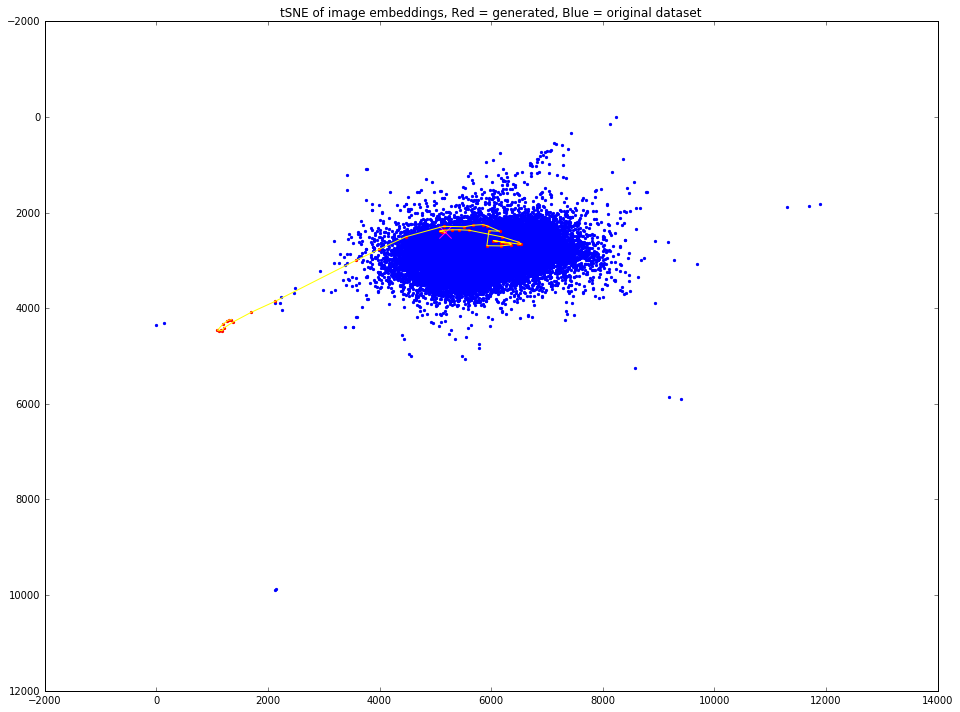

In [91]:
fig1 = plt.figure(figsize = (16,12))
# '.', ',', 'o', 'x'
plt.scatter(points_x_orig, points_y_orig, color="blue", marker=".")
plt.scatter(points_x_gen, points_y_gen, color="red", marker=".", alpha=1.0)

plt.scatter(points_x_gen[0], points_y_gen[0], color="magenta", marker="x",alpha=1.0, s=150)
plt.plot(points_x_gen, points_y_gen, color="yellow",alpha=1.0)
#plt.arrow(points_x_gen[0], points_y_gen[0],points_x_gen[1]-points_x_gen[0], points_y_gen[1]-points_y_gen[0], color="magenta",alpha=1.0)


plt.title("tSNE of image embeddings, Red = generated, Blue = original dataset")
#imshow(point_image)
# Red = generated, Blue = original dataset
plt.gca().invert_yaxis()


# ZOOM-ing
xmin = 1000
xmax = 2000

ymin = 3200
ymax = 2500

#plt.axis([xmin,xmax,ymin,ymax])


fig1.savefig('results/29Apr_last_points_50Gen_30kOrig.png') #, bbox_inches='tight'
#fig.savefig('last_points_100kallGen_30kOrig.pdf')

In [81]:
print(images_GEN)

['/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug00.png'
 '/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug01.png'
 '/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug02.png'
 '/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug03.png'
 '/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug04.png'
 '/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug05.png'
 '/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug06.png'
 '/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug07.png'
 '/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug08.png'
 '/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug09.png'
 '/home/kangeunsu/progressive_growing_of_gans/results/interpolation/test1/debug10.png'
 '/home/kangeunsu/progressive_growing_of_ga

In [92]:
full_image = Image.new('RGBA', (width, height))

sub = 100# -1

# ORIG PART
for img, x, y in tqdm(zip(images_ORIG[0:sub], tx_ORIG[0:sub], ty_ORIG[0:sub])):
    tile = Image.open(img)
    rs = max(1, tile.width/tile_size, tile.height/tile_size)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    tile.putalpha(200)
    full_image.paste(tile, (int((width-tile_size)*x), int((height-tile_size)*y)), mask=tile.convert('RGBA'))
    
tile_size = 100 # size of the tiles

sub = 50

# GEN PART
for img, x, y in tqdm(zip(images_GEN[0:sub], tx_GEN[0:sub], ty_GEN[0:sub])):
    tile = Image.open(img)

    rs = max(1, tile.width/tile_size, tile.height/tile_size)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    
    draw_tile = ImageDraw.Draw(tile, "RGBA")
    
    thickness = 10
    for i in range(0, thickness):
        draw_tile.rectangle([(i, i),(tile_size-i,tile_size-i) ], fill=(255,255,255,0), outline="red")
    tile.putalpha(200)
    # resize after??

    full_image.paste(tile, (int((width-tile_size)*x), int((height-tile_size)*y)), mask=tile.convert('RGBA'))



100it [00:12,  8.22it/s]
50it [00:05,  9.32it/s]


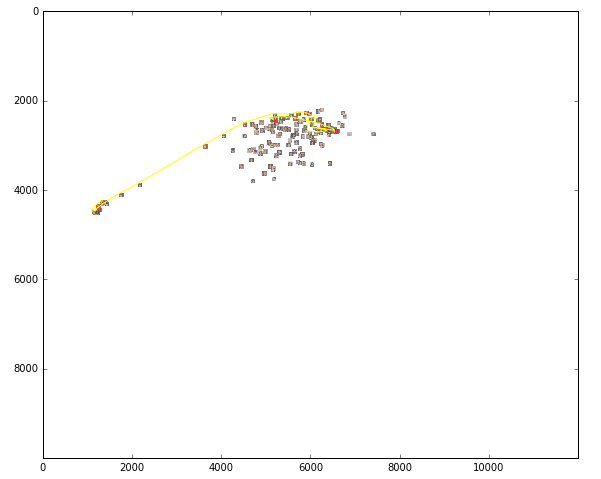

In [93]:
fig = plt.figure(figsize = (16,8))
#plt.gca().invert_yaxis()
plt.plot(points_x_gen, points_y_gen, color="yellow",alpha=1.0)

imshow(full_image)


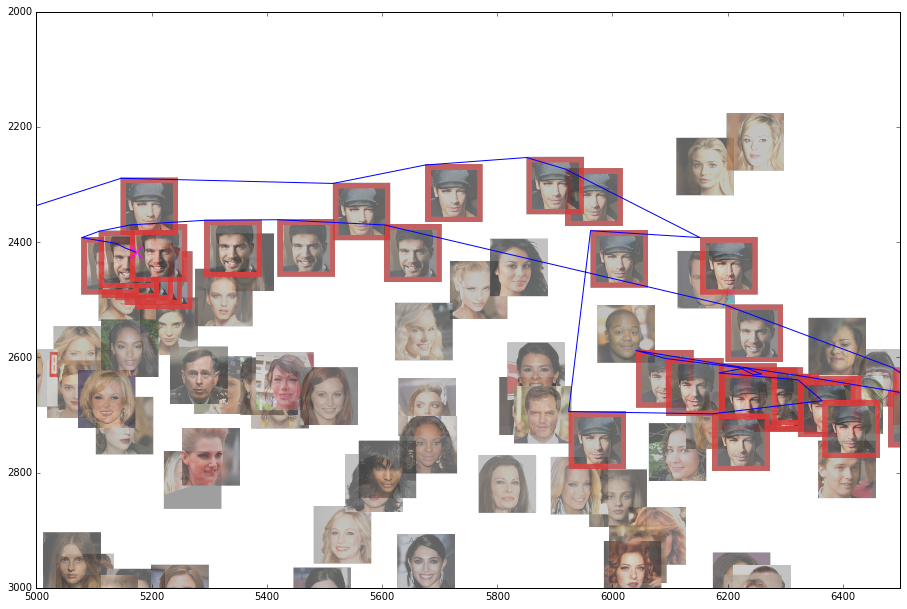

In [96]:
# ZOOM-ing
xmin = 5000
xmax = 6500

ymin = 3000
ymax = 2000


plt.axes([0,0,2,2])
plt.axis([xmin,xmax,ymin,ymax])
plt.plot(points_x_gen, points_y_gen, color="blue",alpha=1.0)
plt.scatter(points_x_gen[0], points_y_gen[0], color="magenta", marker="x",alpha=1.0, s=150)

imshow(full_image)


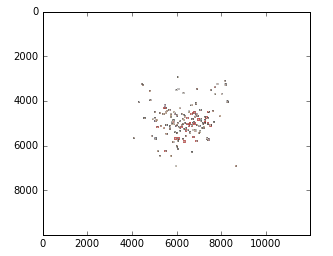

In [41]:
plt.axis()

imshow(full_image)


You can save the image to disk:

In [22]:
full_image.save("./results/24Apr_SNE-OrigGen_CelebAFacenet__30korig__5kgenfrom100k__2000it_perp100.png")
#point_image.save("./results/tSNE-OrigGen_CelebAFacenet__30korig__5kgenfrom100k__2000it_perp100_dots.png")
# plt save plot?

In [32]:
width2 = 24000+1
height2 = 18000+1
just_orig = Image.new('RGBA', (width2, height2))

sub = -1

# ORIG PART
for img, x, y in tqdm(zip(images_ORIG[0:sub], tx_ORIG[0:sub], ty_ORIG[0:sub])):
    tile = Image.open(img)
    rs = max(1, tile.width/tile_size, tile.height/tile_size)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    tile.putalpha(200)
    just_orig.paste(tile, (int((width2-tile_size)*x), int((height2-tile_size)*y)), mask=tile.convert('RGBA'))
    
tile_size = 100 # size of the tiles

sub = 5000

100%|██████████| 29999/29999 [32:51<00:00, 15.22it/s]


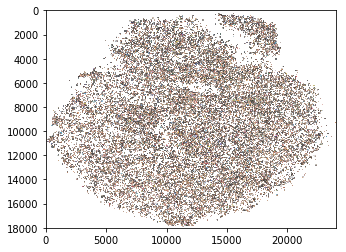

In [33]:
imshow(just_orig)
just_orig.save("./results/24Apr_justOrig_SNE-OrigGen_CelebAFacenet__30korig__5kgenfrom100k__2000it_perp100_"+str(width2)+"x"+str(height2)+".png")


# Experimenting with interactive 3D

In [2]:
import os
import random
import numpy as np
import json
import matplotlib.pyplot as plt

import cPickle as pickle
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
from sklearn.manifold import TSNE
from tqdm import tqdm
from IPython.display import clear_output

In [8]:
# 3D ?
X = np.array(pca_features)
tsne = TSNE(n_components=3, learning_rate=150, perplexity=100, angle=0.2, verbose=1, n_iter=1000).fit_transform(X)
print("done!")

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.100s...
[t-SNE] Computed neighbors for 4000 samples in 27.185s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.181160
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.327248
[t-SNE] Error after 1000 iterations: 1.543225


In [10]:
# save last tSNE
pickle.dump([tsne,images,num_images_to_plot_ORIG, num_images_to_plot_GEN], open('./last_tsne_3d.p', 'wb'))
print("saved! ",os.path.getsize("./last_tsne_3d.p") >> 10, "kB")

('saved! ', 598, 'kB')


In [3]:
# load last tSNE
tsne,images,num_images_to_plot_ORIG, num_images_to_plot_GEN = pickle.load(open('./last_tsne_3d.p', 'r'))
print("loaded!", num_images_to_plot_ORIG, num_images_to_plot_GEN)

('loaded!', 2000, 2000)


<IPython.core.display.Javascript object>


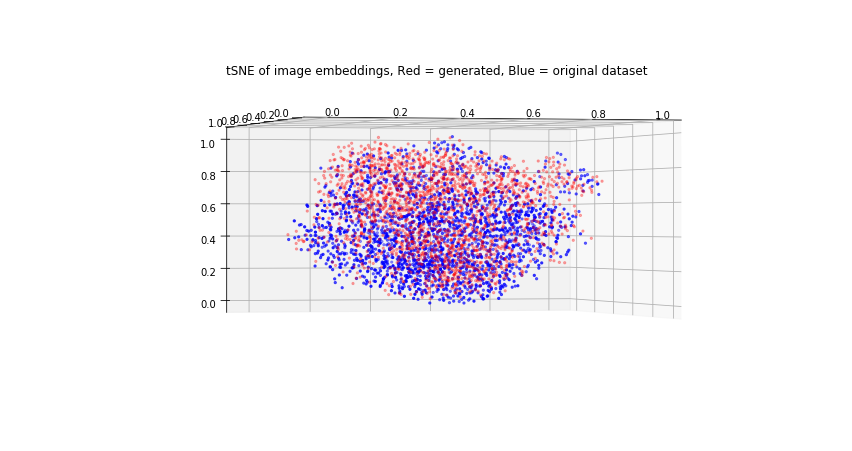

Text(0.5,0.92,u'tSNE of image embeddings, Red = generated, Blue = original dataset')

In [26]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

tx, ty, tz = tsne[:,0], tsne[:,1], tsne[:,2]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
tz = (tz-np.min(tz)) / (np.max(tz) - np.min(tz))

tx_ORIG = tx[0:num_images_to_plot_ORIG]
ty_ORIG = ty[0:num_images_to_plot_ORIG]
tz_ORIG = tz[0:num_images_to_plot_ORIG]
tx_GEN = tx[num_images_to_plot_ORIG:]
ty_GEN = ty[num_images_to_plot_ORIG:]
tz_GEN = tz[num_images_to_plot_ORIG:]

#%matplotlib inline
#%matplotlib qt 
#%matplotlib tk
%matplotlib notebook 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tx_ORIG, ty_ORIG, tz_ORIG, color="blue", marker=".")
ax.scatter(tx_GEN, ty_GEN, tz_GEN, color="red", marker=".", alpha=0.3)
plt.title("tSNE of image embeddings, Red = generated, Blue = original dataset")


In [ ]:
full_image.save("./results/3D_tSNE-OrigGen_CelebAFacenet__30korig_20kgen__full512feature_2000it_perp100.png")
#point_image.save("./results/3D_tSNE-OrigGen_CelebAFacenet__30korig_20kgen_dots__full512feature_2000it_perp100.png")

Now that we have generated our t-SNE, one more nice thing we can optionally do is to take the 2d embedding and assign it to a grid, using [RasterFairy](https://github.com/Quasimondo/RasterFairy). We can optionally choose a grid size of rows (`nx`) and columns (`ny`), which should be equal to the number of images you have. If it is less, then you can simply cut the `tsne` and `images` lists to be equal to `nx * ny`.

If you omit the `target=(nx, ny)` argument, RasterFairy will automatically choose an optimal grid size to be as square-shaped as possible. RasterFairy also has options for embedding them in a grid with irregular borders as well (see the GitHub page for more details).

You can also save the t-SNE points and their associated image paths for further processing in another environment.

In [35]:
tsne_path = "./results/example-tSNE-points-animals.json"

data = [{"path":os.path.abspath(img), "point":[x.astype("float64"), y.astype("float64")]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to ./results/example-tSNE-points-animals.json


In [36]:
import rasterfairy

# nx * ny = 1000, the number of images
nx = 40
ny = 25

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

Now finally, we can make a new image of our grid. Set the `tile_width` and `tile_height` variables according to how big you want the individual tile images to be. The resolution of the output image is `tile_width * nx` x `tile_height * ny`. The script will automatically center-crop all the tiles to match the aspect ratio of `tile_width / tile_height`.

In [37]:
grid_assignment[0].shape

(1000, 2)

In [38]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny

print(full_width)
print(full_height)

2880
1400


In [39]:

aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in tqdm(zip(images, grid_assignment[0])):
    #print(grid_pos)
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))


100%|██████████| 1000/1000 [00:02<00:00, 483.65it/s]


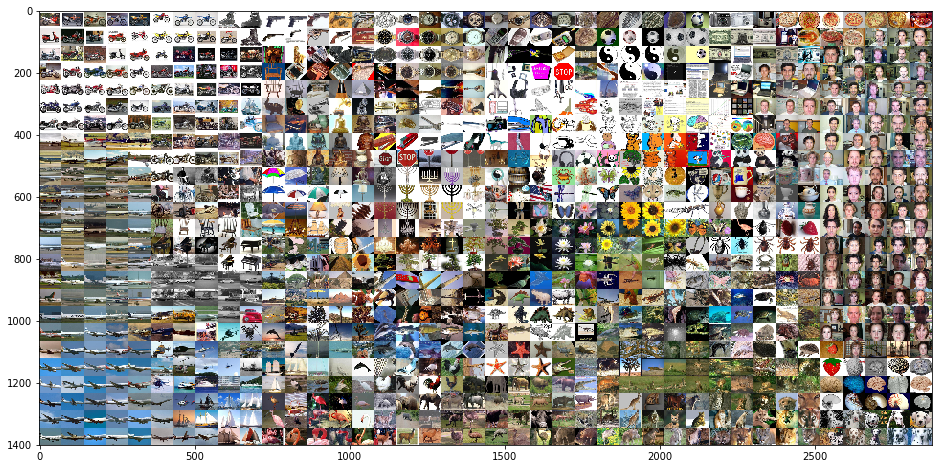

In [40]:
plt.figure(figsize = (16,12))
imshow(grid_image)

Finally, we can save the gridded t-SNE to disk as well.

In [41]:
grid_image.save("./results/example-tSNE-grid-animals.jpg")

## Let us make an animation ##


In [42]:
print(grid_assignment[0].shape)

(1000, 2)


In [43]:
print(nx,ny)

(40, 25)


In [44]:
#!pip install pytweening
import pytweening

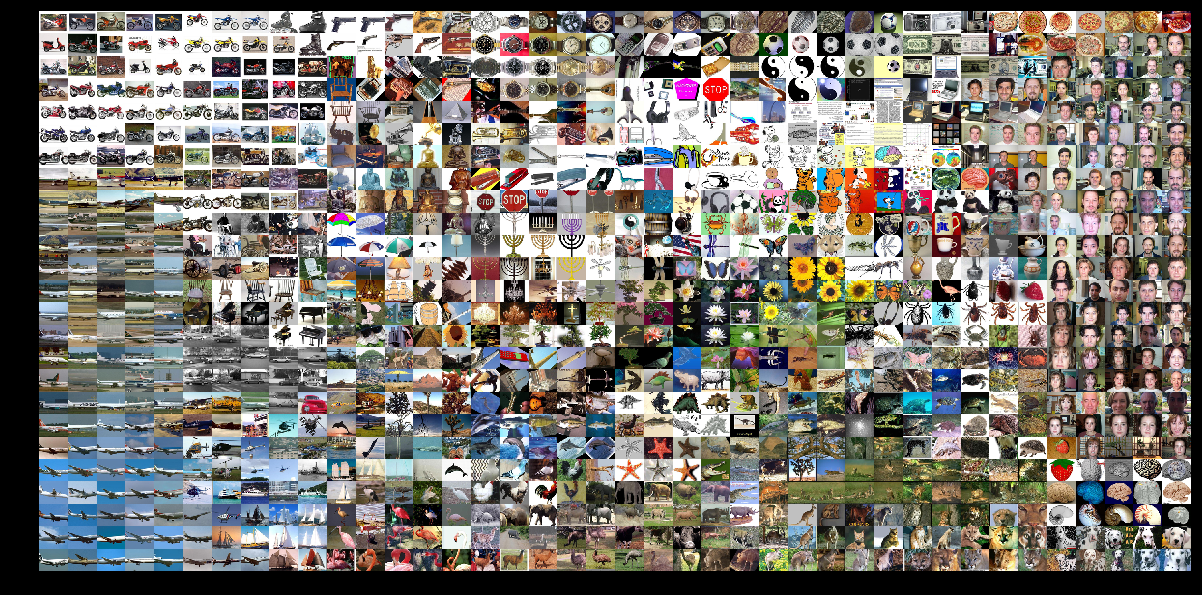

In [46]:
width = full_width #2880 it could be any number
height = full_height #1400 it could be any number
max_dim = 100

print(full_width)
print(full_height)

steps =50

for i in range(steps):
    print(i)
    pctg = pytweening.easeInOutSine(float(i)/(steps-1))
    
    print(pctg)
    
    full_image = Image.new('RGBA', (width, height))

    for img, x,y, grid_pos in tqdm(zip(images, tx, ty, grid_assignment[0])):
        #print(grid_pos)
        idx_x, idx_y = grid_pos
        new_xpos = (width-max_dim)*x*(1-pctg)+pctg*(tile_width * idx_x+width/2-full_width/2)
        new_ypos = (height-max_dim)*y*(1-pctg)+pctg*(tile_height * idx_y+height/2-full_height/2)
        tile = Image.open(img)
        tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
        if (tile_ar > aspect_ratio):
            margin = 0.5 * (tile.width - aspect_ratio * tile.height)
            tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
        else:
            margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
            tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
        tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
        full_image.paste(tile, (int(new_xpos), int(new_ypos)))

    fig = plt.figure(figsize=(16.0,16.0))
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1)
    plt.subplots_adjust(0,0,1,1)

    
    plt.axis("off")
    plt.margins(0.0)
    

    fig.patch.set_facecolor('black')
    
    #plt.rcParams['axes.facecolor']='black'
    plt.rcParams['savefig.facecolor']='black'

    #ax.set_facecolor('black')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.axes.get_xaxis().set_visible(False)
    #ax.axes.get_yaxis().set_visible(False)
    #ax.axes.set_xlim([0.0,dim])
    #ax.axes.set_ylim([0.0,dim])
    #ax.invert_yaxis()
    imshow(full_image)
    clear_output(wait=True)
    plt.savefig('tmpdir/tsne_anim'+"%03d" % (i,)+'.png',bbox_inches="tight")
    plt.show()



In [47]:
import os
frames_dir = './tmpdir'
video_path = './results/tsne_anim_video.mp4'

cmd = 'ffmpeg -i %s/tsne_anim%%03d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" %s' % (frames_dir, video_path)
print(cmd)
os.system(cmd)

ffmpeg -i ./tmpdir/tsne_anim%03d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" ./results/tsne_anim_video.mp4


0

## Let us make an animation using masks ##

In [74]:
totalDataPoints=1000
radius,adjustmentFactor,count = rasterfairy.getBestCircularMatch(totalDataPoints)
print "The smallest circle that can hold",totalDataPoints,"has a radius of",radius,"and will fit",count,"points"

The smallest circle that can hold 1000 has a radius of 18 and will fit 1005 points


In [75]:
#the adjustmentFactor is a value between 0.0 and 1.0 that controls
#if a pixel that is on the edge of the circle will be included or not
arrangement = rasterfairy.getCircularArrangement(radius,adjustmentFactor)

In [76]:
rasterMask = rasterfairy.arrangementToRasterMask(arrangement)

In [77]:
grid_xy,(emb_width,emb_height) = rasterfairy.transformPointCloud2D(tsne,target=rasterMask,autoAdjustCount = True)


In [78]:
grid_xy[0]

array([ 32.,  21.], dtype=float32)

In [82]:
width = emb_width*tile_width
print(width)
height = emb_height*tile_height
print(height)

2520
2072


In [83]:
print(tile_width,tile_height)

(72, 56)


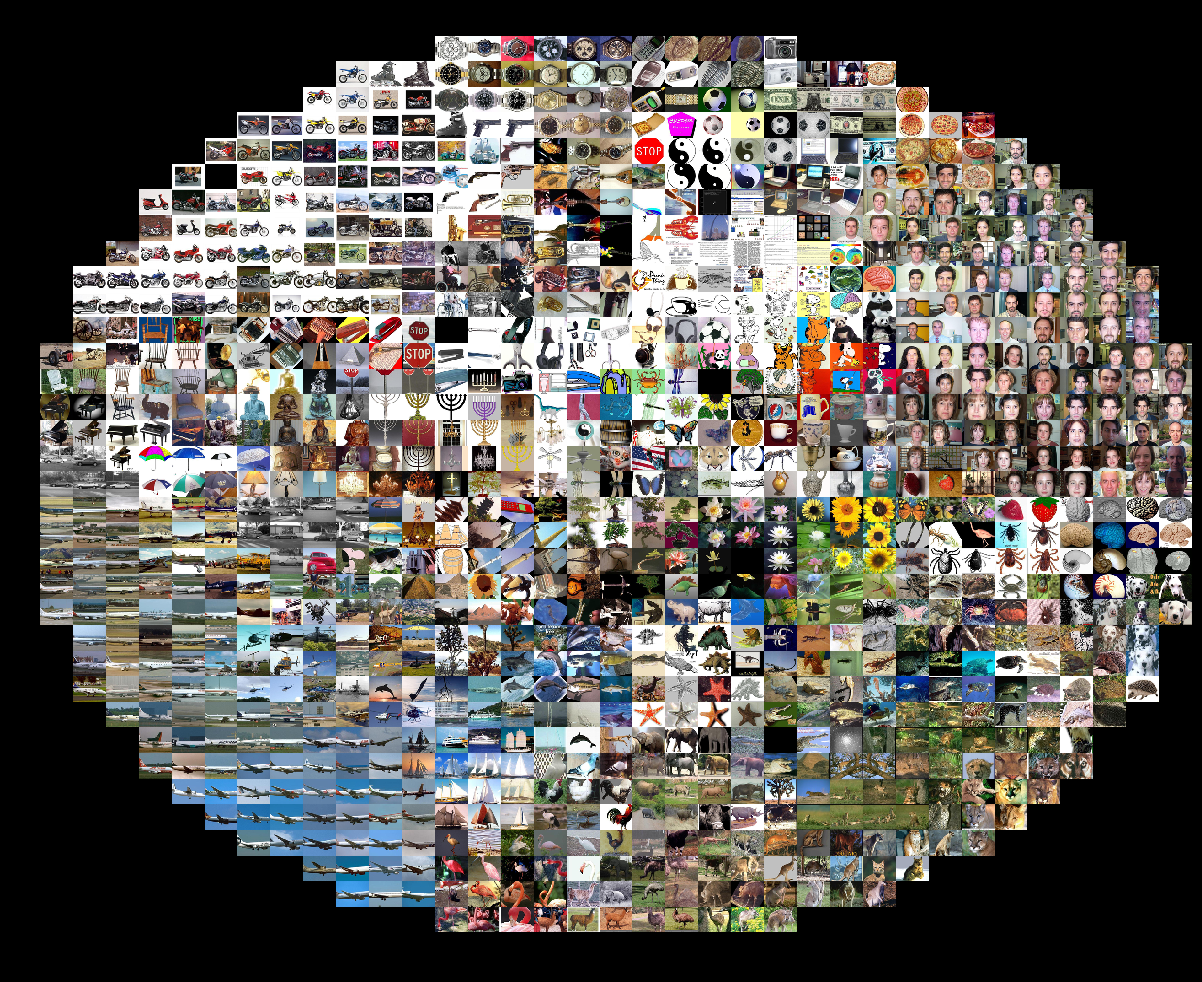

In [88]:
max_dim = 100

print(full_width)
print(full_height)

steps =50

for i in range(steps):
    print(i)
    pctg = pytweening.easeInOutSine(float(i)/(steps-1))
    
    print(pctg)
    
    full_image = Image.new('RGBA', (width, height))

    for img, x,y, grid_pos in tqdm(zip(images, tx, ty, grid_xy)):
        #print(grid_pos)
        idx_x, idx_y = grid_pos
        new_xpos = (width-max_dim)*x*(1-pctg)+pctg*(tile_width * idx_x)
        new_ypos = (height-max_dim)*y*(1-pctg)+pctg*(tile_height * idx_y)
        tile = Image.open(img)
        tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
        if (tile_ar > aspect_ratio):
            margin = 0.5 * (tile.width - aspect_ratio * tile.height)
            tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
        else:
            margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
            tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
        tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
        full_image.paste(tile, (int(new_xpos), int(new_ypos)))

    fig = plt.figure(figsize=(16.0,16.0))
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1)
    plt.subplots_adjust(0,0,1,1)

    
    plt.axis("off")
    plt.margins(0.0)
    

    fig.patch.set_facecolor('black')
    
    #plt.rcParams['axes.facecolor']='black'
    plt.rcParams['savefig.facecolor']='black'

    #ax.set_facecolor('black')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.axes.get_xaxis().set_visible(False)
    #ax.axes.get_yaxis().set_visible(False)
    #ax.axes.set_xlim([0.0,dim])
    #ax.axes.set_ylim([0.0,dim])
    #ax.invert_yaxis()
    imshow(full_image)
    clear_output(wait=True)
    plt.savefig('tmpdir/tsne_circle_anim'+"%03d" % (i,)+'.png',bbox_inches="tight")
    plt.show()




In [89]:
import os
frames_dir = './tmpdir'
video_path = './results/tsne_circle_anim_video.mp4'

cmd = 'ffmpeg -i %s/tsne_circle_anim%%03d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" %s' % (frames_dir, video_path)
print(cmd)
os.system(cmd)

ffmpeg -i ./tmpdir/tsne_circle_anim%03d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" ./results/tsne_circle_anim_video.mp4


0